In [1]:
%matplotlib inline
import matplotlib
print('matplotlib version:', matplotlib.__version__)
import matplotlib.pyplot as plt

import numpy as np
print('numpy version', np.__version__)
from numpy import median

import pandas as pd
print('pandas version:', pd.__version__)
from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sns
print('seaborn version:', sns.__version__)
cmap = sns.cm.rocket_r
sns.set_style("white")

import scipy as sci
import scipy.sparse
print('scipy version:', sci.__version__)
from scipy import spatial
from scipy.stats import(kstest, poisson)

import scanpy as sc
sc.logging.print_version_and_date()
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

import anndata
print('anndata version:', anndata.__version__)
from anndata import read_h5ad
from anndata import AnnData

matplotlib version: 3.5.1
numpy version 1.21.6
pandas version: 1.4.1
seaborn version: 0.11.2
scipy version: 1.8.0
Running Scanpy 1.9.1, on 2022-06-08 19:20.
anndata version: 0.8.0


In [2]:
from adjustText import adjust_text
import gseapy as gp
print('gseapy version:', gp.__version__)

import mygene
mg = mygene.MyGeneInfo()
print('mygene version:', mygene.__version__)

gseapy version: 0.10.8
mygene version: 3.2.2


In [4]:
from matplotlib.colors import LinearSegmentedColormap
age_color=['#008c5f','#3b9868','#b0df83','#ed7c6a','#e54746','#177cb0','#a3dfdf']
myColors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
colors=['#F7828A',"#F9C7C6","#FDFAF3","#D4E3D0","#9CCCA4",]
c = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
colors.reverse()
c_r=LinearSegmentedColormap.from_list('Custom', colors, len(colors))

In [24]:
def string_interaction(gene,species):
    import requests ## python -m pip install requests
    string_api_url = "https://string-db.org/api"
    output_format = "tsv-no-header"
    method = "network"
    request_url = "/".join([string_api_url, output_format, method])
    my_genes = gene

    params = {

        "identifiers" : "%0d".join(my_genes), # your protein
        "species" : species, # species NCBI identifier 
        "caller_identity" : "www.awesome_app.org" # your app name

    }
    response = requests.post(request_url, data=params)
    res=pd.DataFrame(columns=['stringId_A',\
                             'stringId_B',\
                             'preferredName_A',\
                             'preferredName_B',\
                             'ncbiTaxonId',\
                             'score',\
                             'nscore',\
                             'fscore',\
                             'pscore',\
                             'ascore',\
                             'escore',\
                             'dscore',\
                             'tscore'])
    for line in response.text.strip().split("\n"):
        l = line.strip().split("\t")
        res=res.append({'stringId_A':l[0],\
                             'stringId_B':l[1],\
                             'preferredName_A':l[2],\
                             'preferredName_B':l[3],\
                             'ncbiTaxonId':l[4],\
                             'score':l[5],\
                             'nscore':l[6],\
                             'fscore':l[7],\
                             'pscore':l[8],\
                             'ascore':l[9],\
                             'escore':l[10],\
                             'dscore':l[11],\
                             'tscore':l[12]},ignore_index=True)
    return res

def get_gene_data(genelist):
  vio_data=pd.DataFrame()
  #print(len(res[res.obs['Diagnosis']=='AD'].X.T[0]),len(res[res.obs['Diagnosis']=='Control'].X.T[0]))
  for i in genelist:
    test_1=pd.DataFrame()
    test_1['value']=data.loc[i].values
    test_1['gene']=[k for k in [i]*len(test_1)]
    test_1['type']=['Ctrl','Ctrl','SHED','SHED']
    vio_data=pd.concat([vio_data,test_1],ignore_index=True)
  return vio_data

In [23]:
def string_map(gene,species):
    import requests ## python -m pip install requests
    string_api_url = "https://string-db.org/api"
    output_format = "tsv-no-header"
    method = "get_string_ids"
    params = {

        "identifiers" : "\r".join(gene), # your protein list
        "species" : species, # species NCBI identifier 
        "limit" : 1, # only one (best) identifier per input protein
        "echo_query" : 1, # see your input identifiers in the output
        "caller_identity" : "www.awesome_app.org" # your app name

    }
    request_url = "/".join([string_api_url, output_format, method])
    results = requests.post(request_url, data=params)
    res=pd.DataFrame(columns=['queryItem','queryIndex','stringId','ncbiTaxonId','taxonName','preferredName','annotation'])
    for line in results.text.strip().split("\n"):
        l = line.split("\t")
        res=res.append({'queryItem':l[0],\
          'queryIndex':l[1],\
          'stringId':l[2],\
          'ncbiTaxonId':l[3],\
          'taxonName':l[4],\
          'preferredName':l[5],\
          'annotation':l[6]},ignore_index=True)
    return res


def max_interaction(gene,species):
    gene_len=len(gene)
    times=gene_len//1000
    shengyu=gene_len-times*1000
    if shengyu!=0:
        times+=1
    ge=[]
    for i in range(times):
        ge.append(gene[1000*i:1000*(i+1)])
    b=[]
    for p in itertools.combinations(range(times),2):
        b.append(string_interaction(ge[p[0]]+ge[p[1]],species))
    res=pd.concat(b,axis=0,ignore_index=True)
    res=res.drop_duplicates()
    return res
    

def generate_G(gene,species):
    import itertools
    a=string_interaction(gene,species)
    b=a.drop_duplicates()
    b.head()
    import networkx as nx
    G = nx.Graph()
    G.add_nodes_from(set(b['preferredName_A'].tolist()+b['preferredName_B'].tolist()))

    #Connect nodes
    for i in b.index:
        col_label = b.loc[i]['preferredName_A']
        row_label = b.loc[i]['preferredName_B']
        if(float(b.loc[i]['score'])>0.4):
            G.add_edge(col_label,row_label)
    return G

# Figure 3 Different Protein Analysis

## data prepare

In [6]:
data=pd.read_csv('data/c57_res.csv')
data.set_index(data.columns[0],inplace=True)
data.head()

,Ctrl-1,Ctrl-2,SHED-1,SHED-2
Unnamed: 0,,,,
Tuba1a,0.157760,0.156648,0.184710,0.188106
Psap,0.161794,0.160559,0.184381,0.184491
Me1,0.151054,0.144038,0.184993,0.211506
Acta1,0.154919,0.163582,0.206077,0.177621
Ctsd,0.162781,0.160574,0.192656,0.187705


In [8]:
C57_SHED=pd.read_csv('data/C57_SHED.csv')
C57_SHED.set_index(C57_SHED.columns[0],inplace=True)
C57_SHED.head()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_WT,mean_SHED,ngood_WT,ngood_SHED,sig,log(pvalue),Symbol
Unnamed: 0,,,,,,,,,,,,,,,
987,P68369,0.220082,-2.590593,-5.958664,0.000009,0.008006,3.686946,True,-2.700634,-2.480552,9,9,up,5.063184,Tuba1a
380,E9PZ00,0.171564,-2.588487,-5.251288,0.000041,0.019128,2.265152,True,-2.674269,-2.502705,9,9,up,4.383906,Psap
629,P06801,0.304531,-2.598663,-4.929881,0.000086,0.023777,1.599288,True,-2.750929,-2.446398,9,9,up,4.067928,Me1
984,P68134,0.252243,-2.594415,-4.849587,0.000103,0.023777,1.431374,True,-2.720537,-2.468293,9,9,up,3.988400,Acta1
471,F8WIR1,0.190898,-2.590071,-4.745524,0.000130,0.024133,1.212953,True,-2.685520,-2.494622,9,9,up,3.885024,Ctsd


In [9]:
import pandas as pd 
prodat=pd.read_csv('data/prodat.csv')
prodat.set_index(prodat.columns[0],inplace=True)
prodat.head()

,WT1-1,WT1-2,WT1-3,WT2-1,WT2-2,WT2-3,WT3-1,WT3-2,WT3-3,SHED1-1,...,APP/PS1+SHED1-3,APP/PS1+SHED2-1,APP/PS1+SHED2-2,APP/PS1+SHED2-3,APP/PS1+HUCMSC1-1,APP/PS1+HUCMSC1-2,APP/PS1+HUCMSC1-3,APP/PS1+HUCMSC2-1,APP/PS1+HUCMSC2-2,APP/PS1+HUCMSC2-3
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
A0A075B5P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6A0,NaN,0.144674,0.149574,NaN,0.168654,0.174608,NaN,0.149308,0.159984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A076FR46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.170597,0.165448,0.169335,0.162258,0.167151,0.160413,0.166045,0.165028,0.159244,0.165214
A0A087WNP6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pro_meta=pd.read_csv('data/meta.txt',sep='\t')
pro_meta.head()

,experiment,measure,sample,condition,replicate
0,Ctrl1,Reporter intensity 1,WT1-1,WT,1
1,Ctrl2,Reporter intensity 1,WT1-2,WT,2
2,Ctrl3,Reporter intensity 1,WT1-3,WT,3
3,Ctrl1,Reporter intensity 3,WT3-1,WT,1
4,Ctrl2,Reporter intensity 3,WT3-2,WT,2


In [11]:
o=mg.querymany(qterms=prodat.index.values, scopes='uniprot', fields='symbol', species='mouse',returnall=True)
xl=[]#目标list
out=o['out']#查询结果
dup=[i[0] for i in o['dup']]#提取查询结果中的重复项
dup1={}#重复项存储字典，思路，如果出现了重复项就扔进字典里，第二次出现的时候就判定字典里是否出现过，出现过就认为是重复项，跳过不进行转换
for i in out:
    if 'notfound' in i.keys():#未查询到，保留原始id
        xl.append(i['query'])
    elif 'symbol' not in i.keys():#未查询到，保留原始id
        xl.append(i['query'])
    elif i['query'] in dup:#查到重复项
        if i['query'] in dup1.keys():#出现过就去重
            continue
        else:#没出现过就保留
            xl.append(i['symbol'])
            dup1[i['query']]=1
    else:#正常转换
        xl.append(i['symbol'])
len(xl)

querying 1-1000...done.
querying 1001-1877...done.
Finished.
19 input query terms found dup hits:
	[('A8DUK4', 2), ('P02762', 3), ('P0DP28', 3), ('P17182', 2), ('P50247', 2), ('P61358', 2), ('P62754'
257 input query terms found no hit:
	['A0A075B5P3', 'A0A075B639', 'A0A075B6A0', 'A0A076FR46', 'A0A087WP83', 'A0A087WPC2', 'A0A087WPM5', '


1877

In [12]:
prodat_map=pd.DataFrame()
prodat_map['Uniprot']=prodat.index
prodat_map['Symbol']=xl
prodat_map.head()

,Uniprot,Symbol
0,A0A075B5P3,A0A075B5P3
1,A0A075B639,A0A075B639
2,A0A075B6A0,A0A075B6A0
3,A0A076FR46,A0A076FR46
4,A0A087WNP6,Cdv3


In [13]:
prodat1=prodat.copy()
prodat1.index=xl
prodat1.head()

,WT1-1,WT1-2,WT1-3,WT2-1,WT2-2,WT2-3,WT3-1,WT3-2,WT3-3,SHED1-1,...,APP/PS1+SHED1-3,APP/PS1+SHED2-1,APP/PS1+SHED2-2,APP/PS1+SHED2-3,APP/PS1+HUCMSC1-1,APP/PS1+HUCMSC1-2,APP/PS1+HUCMSC1-3,APP/PS1+HUCMSC2-1,APP/PS1+HUCMSC2-2,APP/PS1+HUCMSC2-3
A0A075B5P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6A0,NaN,0.144674,0.149574,NaN,0.168654,0.174608,NaN,0.149308,0.159984,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A076FR46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.170597,0.165448,0.169335,0.162258,0.167151,0.160413,0.166045,0.165028,0.159244,0.165214
Cdv3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
import numpy as np
C57_SHED=pd.read_csv('data/C57_SHED_WT_result.csv')
C57_SHED['logFC']=C57_SHED['mean_SHED']-C57_SHED['mean_WT']
C57_SHED['sig'] = 'normal'
C57_SHED.loc[(C57_SHED.logFC> 0.1 )&(C57_SHED['P.Value'] < 0.05),'sig'] = 'up'
C57_SHED.loc[(C57_SHED.logFC< -0.1 )&(C57_SHED['P.Value'] < 0.05),'sig'] = 'down'
C57_SHED['log(pvalue)'] = -np.log10(C57_SHED['P.Value'])
C57_SHED['Symbol']=[prodat_map[prodat_map['Uniprot']==i]['Symbol'].values[0] for i in C57_SHED['protein']]
C57_SHED.head()


,Unnamed: 0,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_WT,mean_SHED,ngood_WT,ngood_SHED,sig,log(pvalue),Symbol
0,987,P68369,0.220082,-2.590593,-5.958664,0.000009,0.008006,3.686946,True,-2.700634,-2.480552,9,9,up,5.063184,Tuba1a
1,380,E9PZ00,0.171564,-2.588487,-5.251288,0.000041,0.019128,2.265152,True,-2.674269,-2.502705,9,9,up,4.383906,Psap
2,629,P06801,0.304531,-2.598663,-4.929881,0.000086,0.023777,1.599288,True,-2.750929,-2.446398,9,9,up,4.067928,Me1
3,984,P68134,0.252243,-2.594415,-4.849587,0.000103,0.023777,1.431374,True,-2.720537,-2.468293,9,9,up,3.988400,Acta1
4,471,F8WIR1,0.190898,-2.590071,-4.745524,0.000130,0.024133,1.212953,True,-2.685520,-2.494622,9,9,up,3.885024,F8WIR1


In [15]:
C57_SHED_r=C57_SHED.dropna()
C57_SHED_r[C57_SHED_r['sig']!='normal']

,Unnamed: 0,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_WT,mean_SHED,ngood_WT,ngood_SHED,sig,log(pvalue),Symbol
0,987,P68369,0.220082,-2.590593,-5.958664,0.000009,0.008006,3.686946,True,-2.700634,-2.480552,9,9,up,5.063184,Tuba1a
1,380,E9PZ00,0.171564,-2.588487,-5.251288,0.000041,0.019128,2.265152,True,-2.674269,-2.502705,9,9,up,4.383906,Psap
2,629,P06801,0.304531,-2.598663,-4.929881,0.000086,0.023777,1.599288,True,-2.750929,-2.446398,9,9,up,4.067928,Me1
3,984,P68134,0.252243,-2.594415,-4.849587,0.000103,0.023777,1.431374,True,-2.720537,-2.468293,9,9,up,3.988400,Acta1
4,471,F8WIR1,0.190898,-2.590071,-4.745524,0.000130,0.024133,1.212953,True,-2.685520,-2.494622,9,9,up,3.885024,F8WIR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,862,P52843,0.215851,-2.606822,-2.130114,0.046042,0.182646,-4.100512,False,-2.714747,-2.498896,9,9,up,1.336849,Sult2a1
235,874,P56135,-0.154909,-2.594670,2.115551,0.047403,0.185950,-4.125453,False,-2.517216,-2.672125,9,9,down,1.324194,Atp5j2
236,994,P70296,0.126577,-2.591864,-2.113559,0.047592,0.185950,-4.128858,False,-2.655153,-2.528576,9,9,up,1.322465,Pebp1
237,485,G3UY29,-0.175750,-2.593667,2.172800,0.048016,0.186819,-3.938359,False,-2.505792,-2.681543,6,6,down,1.318612,G3UY29


In [16]:
c57_wt=(prodat1.loc[C57_SHED_r['Symbol'],['WT1-1','WT1-2','WT1-3']].max(axis=1)+
prodat1.loc[C57_SHED_r['Symbol'],['WT3-1','WT3-2','WT3-3']].max(axis=1))/2
c57_wt=c57_wt.dropna()
c57_wt.head()

Tuba1a    0.157204
Psap      0.161176
Me1       0.147546
Acta1     0.159251
F8WIR1    0.161677
dtype: float64

In [17]:
c57_shed=(prodat1.loc[C57_SHED_r['Symbol'],['SHED1-1','SHED1-2','SHED1-3']].max(axis=1)+
prodat1.loc[C57_SHED_r['Symbol'],['SHED3-1','SHED3-2','SHED3-3']].max(axis=1))/2
c57_shed=c57_shed.dropna()
c57_shed.head()

Tuba1a    0.186408
Psap      0.184436
Me1       0.198249
Acta1     0.191849
F8WIR1    0.190181
dtype: float64

## heatmap analysis

In [18]:
gseada=C57_SHED.dropna()
#倍数变化规则
gseada['fcsign']=-np.sign(gseada['logFC'])
gseada['metric']=gseada['log(pvalue)']/gseada['fcsign']
gseada=gseada.sort_values(by=['metric'],ascending=False)
gseada.head()

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1184724699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gseada['fcsign']=-np.sign(gseada['logFC'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1184724699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gseada['metric']=gseada['log(pvalue)']/gseada['fcsign']


,Unnamed: 0,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_WT,mean_SHED,ngood_WT,ngood_SHED,sig,log(pvalue),Symbol,fcsign,metric
6,168,A0A3B2W864,-0.273351,-2.596655,4.458727,0.000252,0.033335,0.607103,True,-2.459979,-2.733330,9,9,down,3.598610,A0A3B2W864,1.0,3.598610
7,717,P19639,-0.202353,-2.591117,4.399405,0.000289,0.033448,0.481234,True,-2.489941,-2.692294,9,9,down,3.539145,Gstm3,1.0,3.539145
11,659,P11087,-0.959961,-2.740195,4.203976,0.000454,0.037694,0.065740,True,-2.260214,-3.220175,9,9,down,3.342881,Col1a1,1.0,3.342881
10,468,F8WHU8,-0.618123,-2.642112,4.583091,0.000459,0.037694,0.149675,True,-2.333051,-2.951174,6,6,down,3.337999,F8WHU8,1.0,3.337999
15,875,P56379,-0.452668,-2.620014,3.988886,0.000747,0.043246,-0.392129,True,-2.393680,-2.846348,9,9,down,3.126540,Atp5mpl,1.0,3.126540


In [19]:
p_liver=prodat[pro_meta[pro_meta['condition']=='WT']['sample']]
col_len=len(p_liver.columns)
p_new=pd.DataFrame(columns=p_liver.columns)

for i in range(len(p_liver)):
  if len(p_liver.iloc[i][p_liver.iloc[i].isna()])==col_len:
    ave=np.nan
  else:
    ave=p_liver.iloc[i][~p_liver.iloc[i].isna()].mean()
  
  p_new.loc[p_liver.index[i]]=p_liver.iloc[i].fillna(ave)

p_liver2=prodat[pro_meta[pro_meta['condition']=='SHED']['sample']]
col_len=len(p_liver2.columns)
p_new2=pd.DataFrame(columns=p_liver2.columns)

for i in range(len(p_liver2)):
  if len(p_liver2.iloc[i][p_liver2.iloc[i].isna()])==col_len:
    ave=np.nan
  else:
    ave=p_liver2.iloc[i][~p_liver2.iloc[i].isna()].mean()
  
  p_new2.loc[p_liver2.index[i]]=p_liver2.iloc[i].fillna(ave)
p_new2


,SHED1-1,SHED1-2,SHED1-3,SHED3-1,SHED3-2,SHED3-3
A0A075B5P3,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B639,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6A0,0.178709,0.162939,0.144740,0.178709,0.207774,0.199383
A0A076FR46,NaN,NaN,NaN,NaN,NaN,NaN
A0A087WNP6,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
Z4YJT3,0.149231,0.145202,0.164990,0.201190,0.164338,0.164990
Z4YJV4,0.169312,0.154477,0.151156,0.180356,0.177402,0.207147
Z4YK03,0.169280,0.151879,0.151879,0.134477,0.151879,0.151879
Z4YKV1,NaN,NaN,NaN,NaN,NaN,NaN


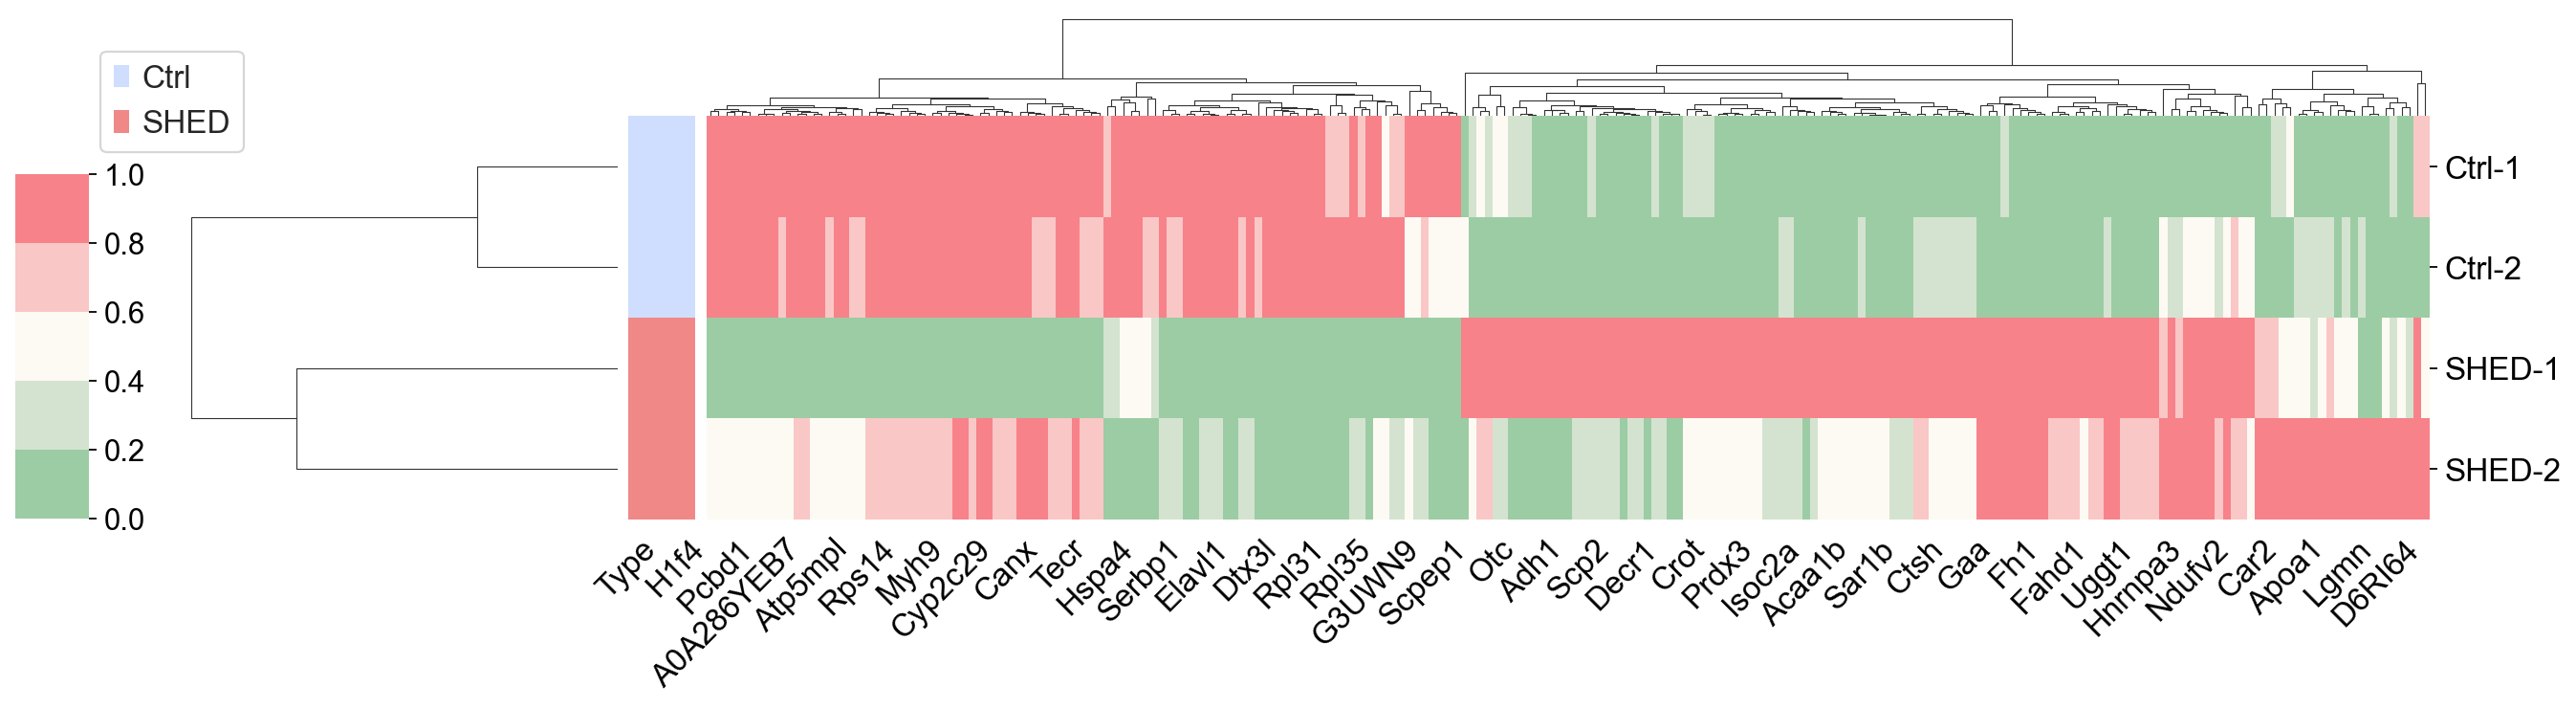

In [21]:
import palettable
#导入数据
fold_cutoff = 0.1
pvalue_cutoff = 0.05
 
#filtered_ids = []  
     
filtered1 = pd.concat([p_new,p_new2],axis=1).loc[C57_SHED[C57_SHED['sig']!='normal']['protein'].values]
filtered1.index=[prodat_map[prodat_map['Uniprot']==i]['Symbol'].values[0] for i in filtered1.index]

filtered1.to_excel('result/C57_SHED_DEG_expression_result.xlsx')
#data1.to_excel('C57_SHED_DEG_result.xlsx')


c57_name=filtered1.columns.tolist()
c57_name=[i.split('-')[0] for i in c57_name]
#print(c57_name)
c57_name1=list(set(c57_name))
c57_name1.sort(key=c57_name.index)
#for i in c57_name:
c57_name1
new_filtered=pd.DataFrame()
for i in c57_name1:
  new_filtered[i]=filtered1.loc[:,filtered1.columns.str.contains(i)].mean(axis=1)
new_filtered.columns=['Ctrl-1','Ctrl-2','SHED-1','SHED-2']

#colors=['#CDA49E',"#C51F1F","#FBF5E7","#9C2632","#471F1F","#764D39","#764D39"]
meta=pd.DataFrame()
meta['id']=new_filtered.columns.tolist()
meta['Type']=['Ctrl','Ctrl','SHED','SHED']
meta=meta.set_index(meta.columns[0])
meta=meta[meta['Type'].isin(['Ctrl','SHED'])]
col_c={
    'SHED':'#F08888',
    'Ctrl':'#CFDEFE'
}
#绘制聚类热图
a=sns.clustermap(new_filtered.T, 
#               cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors, 
               cmap=c_r,
               standard_scale = 1,figsize=(16,5),
              row_colors=meta['Type'].map(col_c).dropna(),
)
#设置聚类热图的横纵坐标标签大小
a.ax_heatmap.yaxis.set_tick_params(labelsize=15)
a.ax_heatmap.xaxis.set_tick_params(labelsize=15)
#设置聚类热图横坐标的内容
#a.ax_heatmap.xaxis.set_ticklabels(['','','TP','','','','','SBI',''])
#设置聚类热图横坐标的旋转角度
labels=a.ax_heatmap.xaxis.get_ticklabels()
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
plt.setp(labels, rotation=45, horizontalalignment='right',fontsize=15)

#绘制组别颜色条
for label in meta['Type'].unique():
    b=a.ax_row_dendrogram.bar(0, 0, color=col_c[label],
                            label=label, linewidth=0)
labels=a.ax_row_colors.xaxis.get_ticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right',fontsize=15)


#绘制组别颜色条的legend
a.ax_row_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-.3, 0.7, 0.5, 0.5),fontsize=15)
#设置legend的位置
a.cax.set_position([-.05, .3, .03, .45])
#设置颜色条的坐标大小
#plt.setp(a.cax.yaxis.get_majorticklabels(), fontsize=15)
plt.savefig("result/Fig_C57_2.png".format(i),dpi=300,bbox_inches = 'tight')

## network 

In [ ]:
rnk_gene=filtered1.index.values
G1=generate_G(rnk_gene,10090)

rt1=string_map(list(prodat_map[prodat_map['Uniprot'].isin(C57_SHED.loc[C57_SHED['sig']=='up']['protein'])]['Symbol'].values),10090)
rt2=string_map(list(prodat_map[prodat_map['Uniprot'].isin(C57_SHED.loc[C57_SHED['sig']=='down']['protein'])]['Symbol'].values),10090)
rt11=rt1['preferredName'].tolist()
rt22=rt2['preferredName'].tolist()
rt111=[i.upper() for i in rt11]
rt222=[i.upper() for i in rt22]

p=dict(G1.nodes)
for i in p.keys():
  if i in rt11:
    p[i]=0
  elif i in rt22:
    p[i]=1
  else:
    p[i]=2

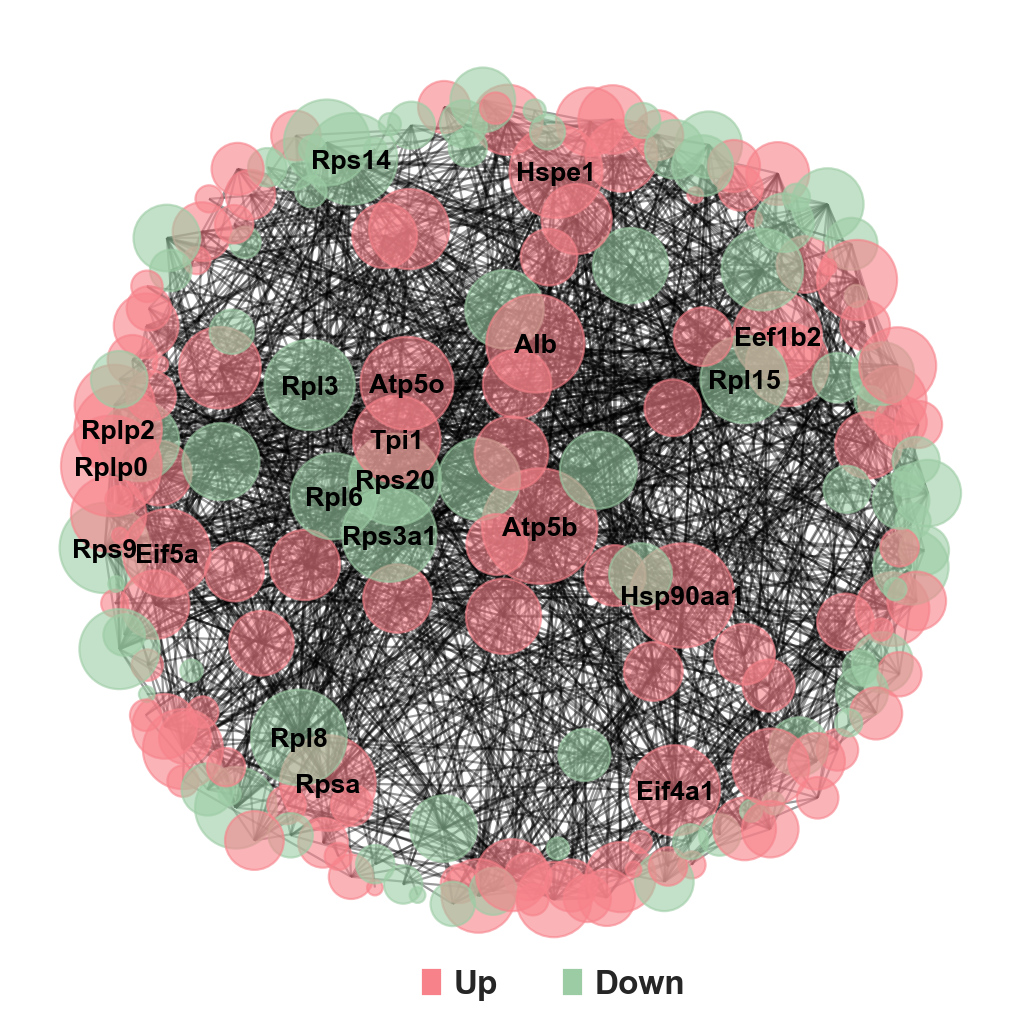

In [26]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(10)
pos = nx.spring_layout(G1, scale=10, k=(len(rnk_gene)//8)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(8, 8))
plt.style.use('seaborn-white')
plt.rc('font', family="Arial")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*50 for v in G1],
    node_color=list(p.values()),
    cmap=c,
    alpha=0.6,
    linewidths=1,
)

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:20]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=12,font_family='Arial',
    font_weight='bold',
)
labels = ['Up', 'Down']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = [colors[-1],colors[0]]
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(0.7, 0.05), ncol=3,fontsize=15)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')
plt.savefig("result/Fig_C57_3.png",dpi=300,bbox_inches = 'tight')

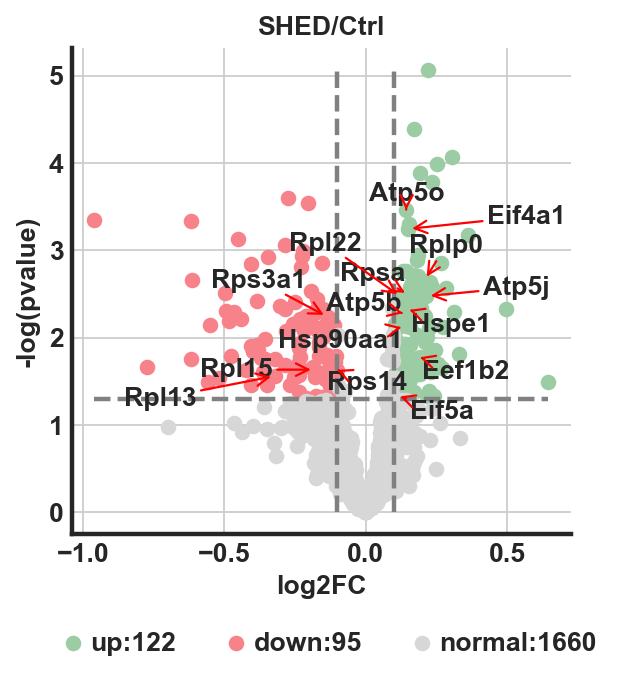

In [27]:
#定义字体
import matplotlib.pyplot as plt
data1=C57_SHED
font1={
    'font':'Arial',
    'size':15,
}
#定义图片大小
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)
#绘制表达上调的基因
plt.scatter(x=data1[data1['sig']=='up']['logFC'],y=data1[data1['sig']=='up']['log(pvalue)'],color=colors[0],label='up')
#绘制表达下调的基因
plt.scatter(x=data1[data1['sig']=='down']['logFC'],y=data1[data1['sig']=='down']['log(pvalue)'],color=colors[4],label='down')
#绘制非差异表达基因
plt.scatter(x=data1[data1['sig']=='normal']['logFC'],y=data1[data1['sig']=='normal']['log(pvalue)'],color='#d7d7d7',label='normal')

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:40]]
hub_gene=['Atp5b','Atp5o','Atp5j','Hsp90aa1','Hspe1','Eif4a1','Eef1b2','Eif5a','Rplp0','Rpsa','Rps3a1','Rps14','Rpl15','Rpl13','Rpl22']
test=prodat_map[prodat_map['Symbol'].isin(hub_gene)]['Uniprot']
texts=[plt.text(data1[data1['protein']==i]['logFC'].values[0], data1[data1['protein']==i]['log(pvalue)'].values[0],
        prodat_map[prodat_map['Uniprot']==i]['Symbol'].values[0]
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(1.2, -.3), ncol=3,fontsize=15)
plt.legend(['up:{0}'.format(len(data1[data1['sig']=='up'])),
      'down:{0}'.format(len(data1[data1['sig']=='down'])),
      'normal:{0}'.format(len(data1[data1['sig']=='normal']))],bbox_to_anchor=(1.1, -0.15), ncol=3,fontsize=12)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12,fontweight='bold')

#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log2FC',fontsize=12,fontweight='bold')
#绘制虚线，padj
ax.plot([data1['logFC'].min(),data1['logFC'].max()],[-np.log10(0.05),-np.log10(0.05)],linewidth=2, linestyle="--",color='grey')
#绘制虚线，表达上调分割线
ax.plot([0.1,0.1],[data1['log(pvalue)'].min(),data1['log(pvalue)'].max()],linewidth=2, linestyle="--",color='grey')
#绘制虚线，表达下调分割线
ax.plot([-0.1,-0.1],[data1['log(pvalue)'].min(),data1['log(pvalue)'].max()],linewidth=2, linestyle="--",color='grey')
#绘制图像标题
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
plt.grid(None)
plt.title('SHED/Ctrl',fontsize=12,fontweight='bold')
plt.savefig("result/Fig_C57_1.png".format(i),dpi=300,bbox_inches = 'tight')

In [28]:
de_pd=pd.DataFrame()
de_pd['Gene']=degree_dict.keys()
de_pd['Degree']=degree_dict.values()
de_pd.to_excel('result/G_degree.xlsx')

In [30]:
def get_xing(gene):
  p=C57_SHED.loc[C57_SHED['Symbol']==gene,'P.Value'].values[0]
  if p<0.001:
    xing='***'
    left=-0.12
  elif p<0.01:
    xing='**'
    left=-0.05
  elif p<0.05:
    xing='*'
    left=-0.03
  else:
    xing=''
    left=-0.0
  return xing,left

def get_heng(gene):
  p=C57_SHED.loc[C57_SHED['Symbol']==gene,'P.Value'].values[0]
  if p<0.001:
    xing='___'
    left=-0.2
  elif p<0.01:
    xing='___'
    left=-0.15
  elif p<0.05:
    xing='___'
    left=-0.1
  else:
    xing=''
    left=0
  return xing,left

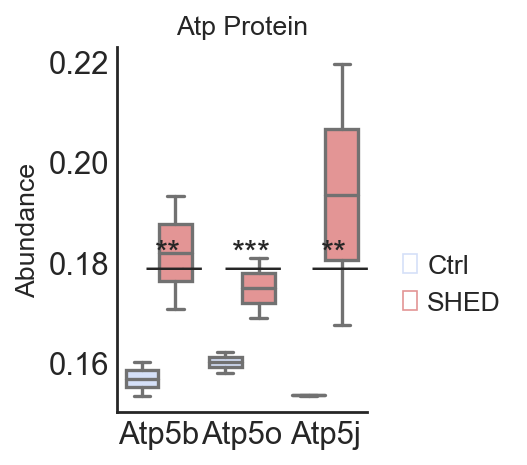

In [32]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(2,3))

#plot_data=get_fc(res_mg_atac.var.loc[mg_res_atac.loc[mg_res_atac['abs_weights']>0.8].index.values]['transcript_annotation'].values)
gene_list=['Atp5b','Atp5o','Atp5j']
col_c={
    'SHED':'#F08888',
    'Ctrl':'#CFDEFE'
}
g=sns.boxplot(x="gene", y="value", hue='type',data=get_gene_data(gene_list), 
        palette=[col_c['Ctrl'],col_c['SHED']],   
        ax=ax,     
              )
handles, _ = g.get_legend_handles_labels()          # Get the artists.
g.legend(handles, ["Ctrl", "SHED"], bbox_to_anchor=(1.05, 0.5), ncol=1,fontsize=12) # Associate manually the artists to a label.

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        line.set_linewidth(3)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')
# Add in points to show each observation
#sns.stripplot(x="cancer", y="value", hue='gene',data=get_disdata_cancer(['ZNF550','KRAS']),
#              palette=["#f2535d","#a2ebc4"],
#              size=4, color=".3", linewidth=0)

for i in range(len(gene_list)):
  plt.text(i+get_xing(gene_list[i])[1],0.18,get_xing(gene_list[i])[0],fontsize=15)
  plt.text(i+get_heng(gene_list[i])[1],0.18,get_heng(gene_list[i])[0],fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xlabel('',fontsize=12)
plt.ylabel('Abundance',fontsize=12)
plt.title('Atp Protein',fontsize=12)

plt.savefig("result/fig_exp_atp.png",dpi=300,bbox_inches = 'tight')

## KEGG

In [59]:
enr = gp.enrichr(gene_list=[i.upper() for i in filtered1.index],
				 gene_sets='KEGG_2019_Mouse',
				 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='C57_SHED',
				 outdir='result/C57_SHED_KEGG',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Ribosome,22/170,1.270397e-17,2.223194e-15,0,0,14.967775,582.315578,RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPL22;RPLP0;...
1,KEGG_2019_Mouse,Alzheimer disease,16/175,8.449551e-11,7.393357e-09,0,0,9.824588,227.874659,UQCRB;NDUFA5;ATP5J;ATP2A2;COX7A2;ATP5O;COX5A;H...
2,KEGG_2019_Mouse,Oxidative phosphorylation,14/134,2.234033e-10,1.303186e-08,0,0,11.300575,251.121850,UQCRB;NDUFA5;ATP5J;COX7A2;ATP5O;COX5A;ATP5J2;A...
3,KEGG_2019_Mouse,Chemical carcinogenesis,12/94,4.289796e-10,1.876786e-08,0,0,14.063772,303.350092,CYP2C37;GSTM3;ADH1;UGT2B36;GSTP1;EPHX1;GSTT3;M...
4,KEGG_2019_Mouse,Metabolism of xenobiotics by cytochrome P450,10/66,2.281508e-09,7.985278e-08,0,0,17.017771,338.626908,GSTM3;ADH1;UGT2B36;GSTP1;EPHX1;GSTT3;MGST1;CYP...


In [60]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.05]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:4: SettingWithCopyWarning: 
A value is trying 

In [35]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

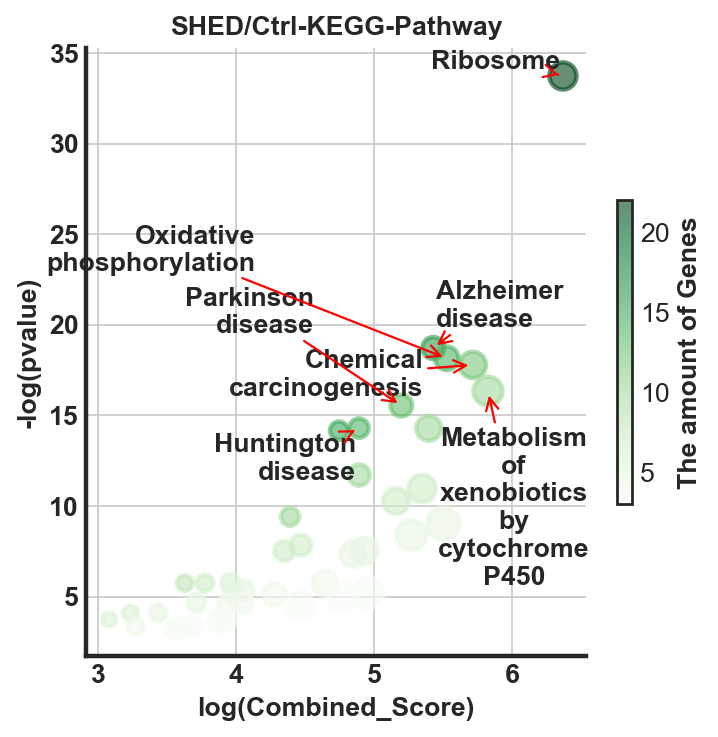

In [36]:
pp=plt.figure(figsize=(5,5))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_ad['logc'],kegg_result_ad['logp'],
      s=kegg_result_ad['Odds Ratio']*10,c=kegg_result_ad['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_ad['Term'].values
texts=[plt.text(kegg_result_ad[kegg_result_ad['Term']==i]['logc'].values[0], kegg_result_ad[kegg_result_ad['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:7]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('SHED/Ctrl-KEGG-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/Fig_C57_KEGG.png",dpi=300,bbox_inches = 'tight')

## Gene ontology

In [37]:
enr = gp.enrichr(gene_list=[i.upper() for i in filtered1.index],
				 gene_sets='GO_Biological_Process_2021',
				 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
				 description='C57_SHED',
				 outdir='result/C57_SHED_GO',
				 # no_plot=True,
				 cutoff=0.5 # test dataset, use lower value from range(0,1)
				)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,SRP-dependent cotranslational protein targetin...,20/90,5.500577e-21,6.906626e-18,0,0,28.590283,1333.720511,RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPLP0;RPL22;...
1,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),20/93,1.115592e-20,6.906626e-18,0,0,27.411168,1259.332533,EIF4A1;RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPLP0...
2,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,20/94,1.403786e-20,6.906626e-18,0,0,27.039374,1236.038191,RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPLP0;RPL22;...
3,GO_Biological_Process_2021,protein targeting to ER (GO:0045047),20/103,9.845064e-20,3.632829e-17,0,0,24.096386,1054.571847,RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPL22;RPLP0;...
4,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",20/113,6.883644e-19,2.032052e-16,0,0,21.494460,898.897640,RPS9;RPL3;RPL31;RPL34;RPLP1;RPL12;RPL22;RPLP0;...


In [38]:
kegg_result_ad=enr.res2d[enr.res2d['Adjusted P-value']<0.05]
kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
kegg_result_ad['num']=[int(i.split('/')[0]) for i in kegg_result_ad['Overlap']]

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logp']=-np.log(kegg_result_ad['Adjusted P-value'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg_result_ad['logc']=np.log(kegg_result_ad['Combined Score'])
/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/1565130830.py:4: SettingWithCopyWarning: 
A value is trying 

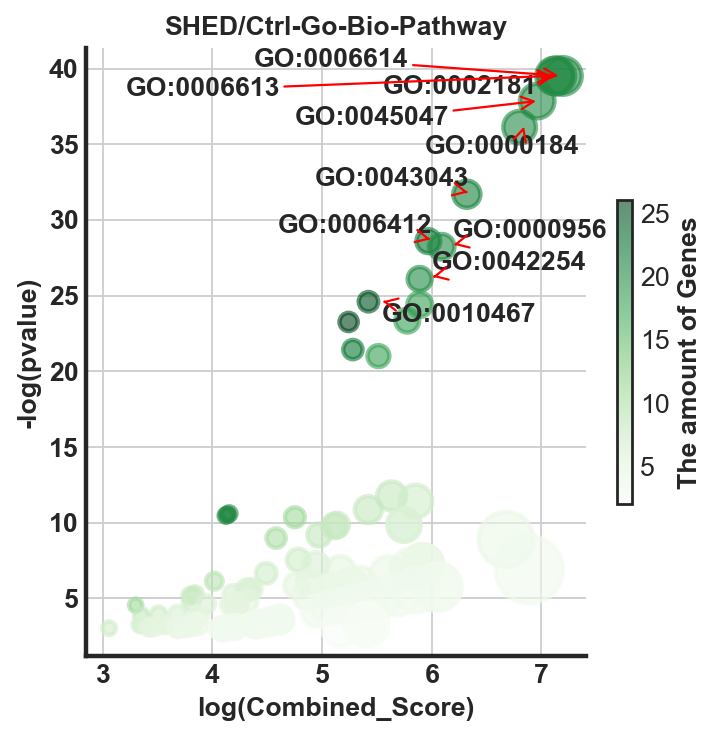

In [39]:
pp=plt.figure(figsize=(5,5))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_ad['logc'],kegg_result_ad['logp'],
      s=kegg_result_ad['Odds Ratio']*10,c=kegg_result_ad['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_ad['Term'].values
texts=[plt.text(kegg_result_ad[kegg_result_ad['Term']==i]['logc'].values[0]+(j*0.01), kegg_result_ad[kegg_result_ad['Term']==i]['logp'].values[0]+(j*0.01),
        i.split('(')[1].replace(')','')
        ,fontdict={'size':12,'weight':'bold'}) for i,j in zip(test[:10],range(10))]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('SHED/Ctrl-Go-Bio-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
plt.grid(None)
cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/Fig_C57_Go.png",dpi=300,bbox_inches = 'tight')

# Figure 4 Liver clock

In [42]:
adata=anndata.read_h5ad('data/C57_liver.h5ad')
adata

AnnData object with n_obs × n_vars = 7294 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [43]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


filtered out 4203 genes that are detected in less than 3 cells


In [45]:
c57_res=pd.DataFrame(index=prodat1.loc[C57_SHED_r['Symbol'],['WT1-1','WT1-2','WT1-3']].max(axis=1).index)
c57_res['Ctrl-1']=prodat1.loc[C57_SHED_r['Symbol'],['WT1-1','WT1-2','WT1-3']].max(axis=1).values
c57_res['Ctrl-2']=prodat1.loc[C57_SHED_r['Symbol'],['WT3-1','WT3-2','WT3-3']].max(axis=1).values
c57_res['SHED-1']=prodat1.loc[C57_SHED_r['Symbol'],['SHED1-1','SHED1-2','SHED1-3']].max(axis=1).values
c57_res['SHED-2']=prodat1.loc[C57_SHED_r['Symbol'],['SHED3-1','SHED3-2','SHED3-3']].max(axis=1).values
c57_res.head()

,Ctrl-1,Ctrl-2,SHED-1,SHED-2
Tuba1a,0.157760,0.156648,0.184710,0.188106
Psap,0.161794,0.160559,0.184381,0.184491
Me1,0.151054,0.144038,0.184993,0.211506
Acta1,0.154919,0.163582,0.206077,0.177621
F8WIR1,0.162781,0.160574,0.192656,0.187705


## Figure A PCA

In [46]:
#pca plot
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
tool = MinMaxScaler(feature_range=(0, 1)) #根据需要设置最大最小值，这里设置最大值为1.最小值为0
data=c57_wt
ret_gene=data.index.tolist()
adata_gene=adata.var.index.tolist()
ret_gene1=list(set(ret_gene) & set(adata_gene))
ret_gene2=adata[:,ret_gene1].to_df().mean()[adata[:,ret_gene1].to_df().mean()>30].index.tolist()
ret_gene3=data.loc[ret_gene2].sort_values().index.tolist()


test_df=pd.DataFrame(columns=ret_gene3)
for i in adata.obs['mouse.id'].unique():
  #a=tool.fit_transform(np.array(c57_wt.loc[ret_gene]).reshape(-1, 1)).T[0]
  #b=tool.fit_transform(np.array(adata[adata.obs['mouse.id']==i,ret_gene].to_df().mean()).reshape(-1, 1)).T[0]
  if i=='21-F-54':
    continue
  b=np.array(adata[adata.obs['mouse.id']==i,ret_gene3].to_df().mean())
  b, _ = stats.boxcox(b)
  b=tool.fit_transform(np.array(b).reshape(-1, 1)).T[0]
  test_df.loc[i]=b
for j in ['Ctrl-1','Ctrl-2','SHED-1','SHED-2']:
  a=stats.boxcox(c57_res.loc[ret_gene3,j].values)[0]
  test_df.loc[j]=tool.fit_transform(np.array(a).reshape(-1, 1)).T[0]
#a=stats.boxcox(c57_wt.loc[ret_gene3])[0]
#test_df.loc['Ctrl']=tool.fit_transform(np.array(a).reshape(-1, 1)).T[0]
#a=stats.boxcox(c57_shed.loc[ret_gene3])[0]
#test_df.loc['SHED']=tool.fit_transform(np.array(a).reshape(-1, 1)).T[0]
test_df.head()

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


,Apoa1,Trf,Rplp1,Alb,Apoa2,Serpina3k,Fabp1,Rpl37a,Rpl32,Rps14,Apoe,Tmsb4x,Tpt1,Ttr,B2m,Eef1a1,Fth1,Rps29,Rpl13,Ftl1
18-F-51,0.443685,0.492984,0.141974,0.830220,0.831005,0.000000,0.251753,0.443870,0.191876,0.285361,1.000000,0.902157,0.054155,0.401055,0.569309,0.403694,0.602831,0.654776,0.319758,0.901547
24-M-58,0.751148,0.703738,0.361358,1.000000,0.899959,0.628788,0.663280,0.398933,0.263005,0.327552,0.890145,0.000000,0.402494,0.718743,0.487506,0.517779,0.512846,0.407948,0.268686,0.544882
24-M-59,0.204433,0.199070,0.520172,0.473970,0.279930,0.000000,0.087371,0.518457,0.502046,0.479235,0.697159,1.000000,0.468278,0.209107,0.565001,0.578272,0.670205,0.656296,0.493957,0.839952
30-M-3,0.104360,0.325905,0.575293,0.153093,0.092979,0.000000,0.034296,0.537981,0.616122,0.583468,0.794425,1.000000,0.512521,0.087158,0.659081,0.583411,0.756300,0.628466,0.585603,0.859225
30-M-4,0.049425,0.296105,0.654292,0.410779,0.060219,0.028122,0.000000,0.730491,0.647869,0.670127,0.994026,1.000000,0.649823,0.171719,0.760511,0.745597,0.701612,0.881711,0.727084,0.691547


In [47]:
test_adata=anndata.AnnData(test_df.values)
test_adata.obs.index=test_df.index
test_adata.var.index=test_df.columns
test_adata

/var/folders/4m/2xw3_2s503s9r616083n7w440000gn/T/ipykernel_58395/674334564.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  test_adata=anndata.AnnData(test_df.values)


AnnData object with n_obs × n_vars = 15 × 20

In [48]:
sc.tl.pca(test_adata)
sc.pp.neighbors(test_adata, use_rep="X_pca", metric="cosine")
sc.tl.umap(test_adata,random_state=1000)
test_adata.obs['Age']=[i.split('-')[0] for i in test_adata.obs.index]
test_adata

computing PCA
    with n_comps=14
    finished (0:00:00)
computing neighbors


/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


AnnData object with n_obs × n_vars = 15 × 20
    obs: 'Age'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'Age' as categorical


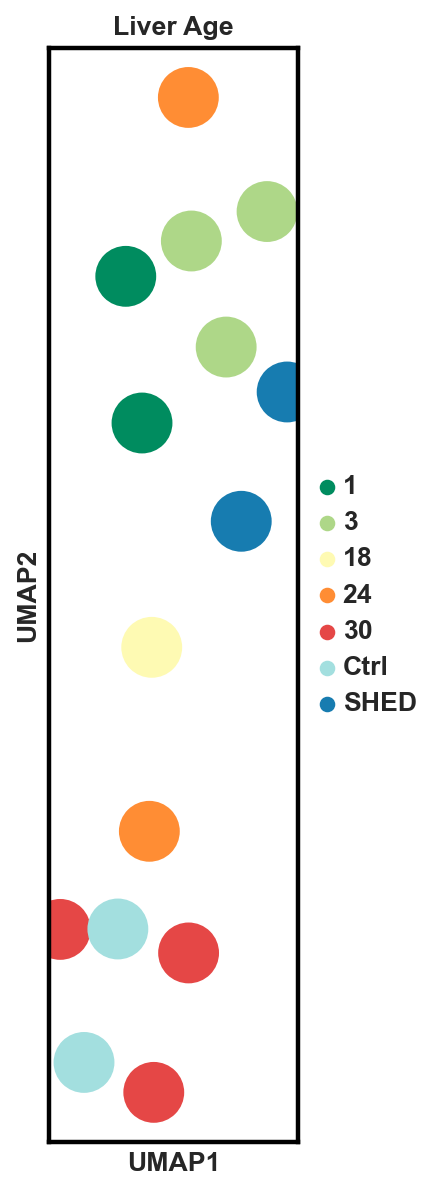

In [49]:
plot_adata=test_adata
age_color=['#008c5f','#aed788','#fefab3','#ff8d34','#e54746','#a3dfdf','#177cb0']
sc.set_figure_params(scanpy=True, fontsize=12,figsize=(2,9))
ax1=sc.pl.umap(plot_adata, color=["Age"], 
               title=['Liver Age'],size=3000,
           wspace=0.3,palette=age_color,return_fig=True,)
ax1=plt.gca()
#ax1.spines['top'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(True)
#ax1.spines['left'].set_visible(True)

ax1.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax1.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax1.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax1.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=12,fontweight='bold')

plt.xlabel('UMAP1',fontsize=12,fontweight='bold')
plt.ylabel('UMAP2',fontsize=12,fontweight='bold')
plt.title('Liver Age',fontsize=12,fontweight='bold')

plt.savefig("result/Fig_umap1.png",dpi=300,bbox_inches = 'tight')

## Figure B-G Correlation

In [50]:
#pca plot

#ret_gene=data.index.tolist()
ret_gene=list(set(adata.var.index) & set(c57_shed.index))
test_df=pd.DataFrame(columns=ret_gene)
for i in adata.obs['mouse.id'].unique():
  if i=='21-F-54':
    continue
  b=np.array(adata[adata.obs['mouse.id']==i,ret_gene].to_df().mean())
  test_df.loc[i]=b

test_df.head()

,Eif4a1,Cyp2d26,Car3,Hba-a1,Otc,Acly,Serpina1b,Ugt2b1,Hsdl2,Fth1,...,Acaa1a,Echs1,Mettl7b,Csnk2a1,Agmat,Usp5,H3f3a,Sdhb,Hdgf,Elavl1
18-F-51,2.045845,1.780802,2.277937,0.104585,0.931232,0.912607,9.724928,0.202006,0.252149,28.418339,...,0.676218,0.895415,1.320917,0.469914,0.323782,0.209169,3.458453,1.126075,0.772206,0.491404
24-M-58,1.907895,6.092105,20.013159,0.000000,3.447368,2.315789,43.697369,2.789474,0.750000,32.486843,...,2.342105,3.289474,5.078948,0.894737,1.197368,0.368421,1.934211,2.131579,1.657895,0.539474
24-M-59,5.883721,0.976744,2.674419,0.418605,0.279070,1.697674,5.000000,0.209302,0.418605,117.697678,...,1.325581,0.930233,0.558140,1.255814,0.093023,0.697674,17.860466,2.255814,2.372093,1.046512
30-M-3,7.809019,0.014324,0.014324,0.003183,0.010080,0.952255,0.260477,0.004244,0.259947,221.415909,...,2.508753,0.945889,0.022281,0.810080,0.002122,0.581432,23.033422,3.132096,2.661538,1.361273
30-M-4,3.739130,0.000000,0.086957,0.239130,0.000000,0.456522,0.086957,0.000000,0.347826,40.456520,...,0.826087,0.782609,0.021739,0.891304,0.000000,0.260870,9.152174,1.000000,1.108696,0.521739


In [51]:
test_adata=anndata.AnnData(test_df.values)
test_adata.obs.index=test_df.index
test_adata.var.index=test_df.columns
test_adata

AnnData object with n_obs × n_vars = 11 × 788

In [52]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats,special
import seaborn as sns
import matplotlib.pyplot as plt

def predicted_age(data,data_name='Data',max_gene=10,save_path=None):
  tool = MinMaxScaler(feature_range=(-1, 1)) #根据需要设置最大最小值，这里设置最大值为1.最小值为0

  ret_gene=data.index.tolist()
  adata_gene=test_adata.var.index.tolist()
  ret_gene1=list(set(ret_gene) & set(adata_gene))
  ret_gene2=test_adata[:,ret_gene1].to_df().mean()[test_adata[:,ret_gene1].to_df().mean()>max_gene].index.tolist()
  ret_gene3=data.loc[ret_gene2].sort_values().index.tolist()

  a=data.loc[ret_gene3].values
  a, _ = stats.boxcox(a)


  cor_pd=pd.DataFrame(columns=['cor','pvalue'])
  for i in test_adata.obs.index:
    b=test_adata[i,ret_gene3].to_df().values[0]
    b, _ = stats.boxcox(b)
    cor_pd.loc[i]=stats.pearsonr(a,b)
    #print(i,stats.pearsonr(a,b))
  #return cor_pd

  
  max_index=cor_pd.sort_values('cor').iloc[-1].name
  b=test_adata[max_index,ret_gene3].to_df().values[0]
  b, _ = stats.boxcox(b)

  a=tool.fit_transform(np.array(a).reshape(-1, 1)).T[0]
  b=tool.fit_transform(np.array(b).reshape(-1, 1)).T[0]
  plot_data=pd.DataFrame(index=ret_gene3)
  plot_data['data']=a
  plot_data[max_index]=b

  #pp=plt.figure(figsize=(4,4))
  #用ax控制图片
  #ax=pp.add_subplot(1,1,1)
  sns.lmplot(x='data',y=max_index,data=plot_data,height=4)
  plt.xlabel(data_name,fontsize=15,fontweight='bold')
  plt.ylabel('Month: {}'.format(max_index.split('-')[0]),fontsize=15,fontweight='bold')
  
  plt.title('Predicted age: {}\ncor:{:.2f} pvalue:{:.2f}'.format(max_index.split('-')[0],
                                                         cor_pd.loc[max_index,'cor'],
                                                         cor_pd.loc[max_index,'pvalue']),fontweight='bold')
  plt.xticks(np.arange(-1,1.1, 0.5),fontsize=12,fontweight='bold')
  plt.yticks(np.arange(-1,1.1, 0.5),fontsize=12,fontweight='bold')
  plt.grid(None)

  ax=plt.gca();#获得坐标轴的句柄
  ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
  ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
  ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
  ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

  
  if save_path==None:
    plt.savefig("Fig_{}.png".format(data_name),dpi=300,bbox_inches = 'tight')
  else:
    plt.savefig(save_path+"Fig_{}.png".format(data_name),dpi=300,bbox_inches = 'tight')


  new_cor_pd=pd.DataFrame(columns=['cor','pvalue'])
  for i in ['1-','3-','18-','24-','30-']:
    new_cor_pd.loc[i]=cor_pd[cor_pd.index.str.contains(i)].mean()

  return cor_pd


### Ctrl

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_meth

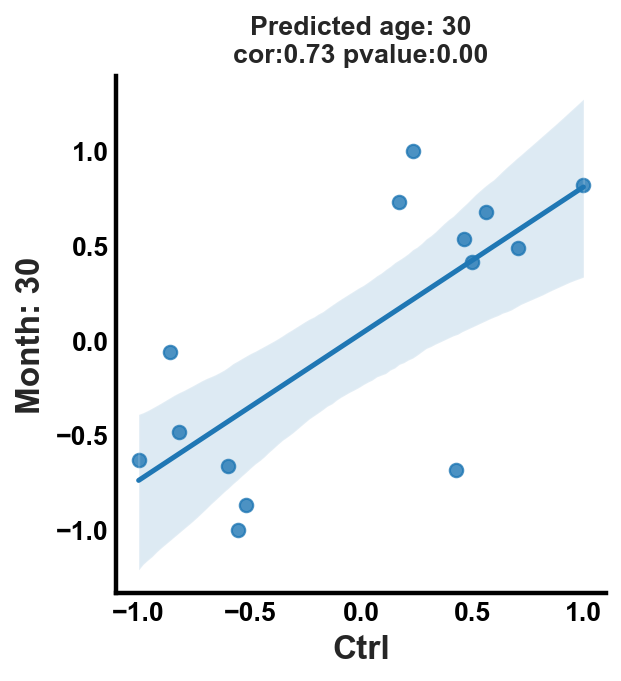

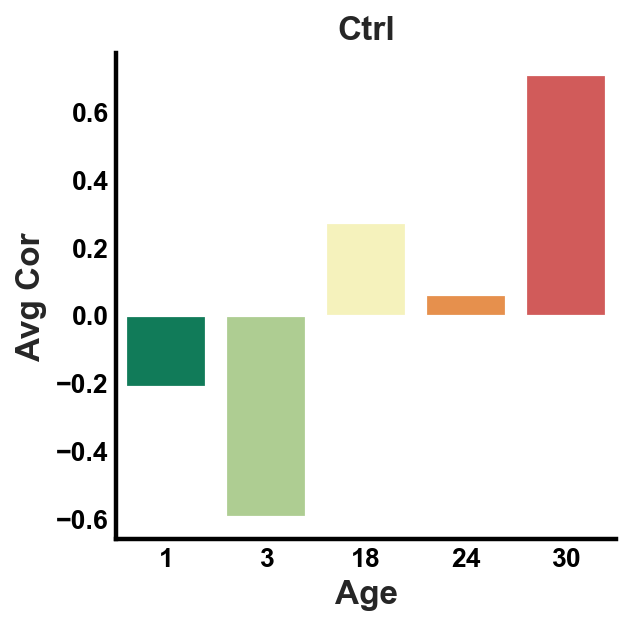

In [53]:
p_d=predicted_age(c57_wt,'Ctrl',max_gene=40,save_path='result/')

new_cor_pd=pd.DataFrame(columns=['cor','pvalue'])
for i in ['1-','3-','18-','24-','30-']:
  new_cor_pd.loc[i.split('-')[0]]=p_d[p_d.index.str.contains(i)].mean()

pp=plt.figure(figsize=(4,4))
  #用ax控制图片
ax=pp.add_subplot(1,1,1)

sns.barplot(x=new_cor_pd.index,y=new_cor_pd['cor'].tolist(),
            palette=age_color,ax=ax)
#ax.grid(None)
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
plt.xlabel('Age',fontsize=15,fontweight='bold')
plt.ylabel('Avg Cor',fontsize=15,fontweight='bold')
plt.title('Ctrl',fontsize=15,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.savefig("result/Fig_cor_{}.png".format('Ctrl'),dpi=300,bbox_inches = 'tight')

### SHED

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


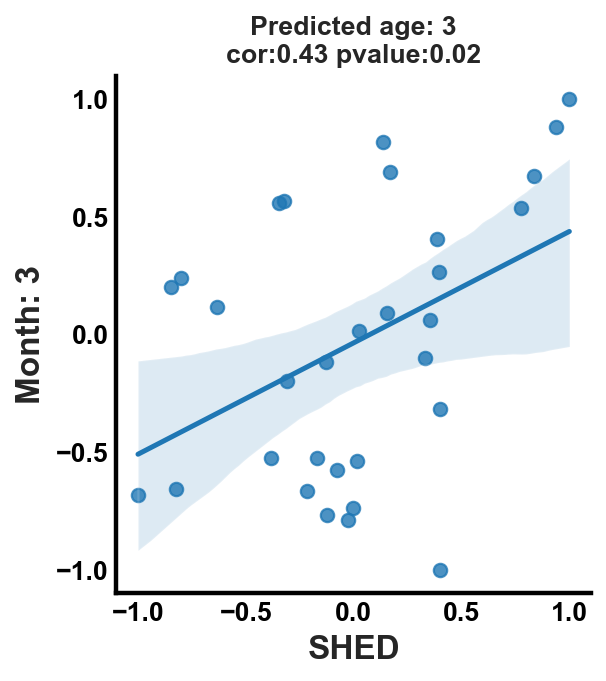

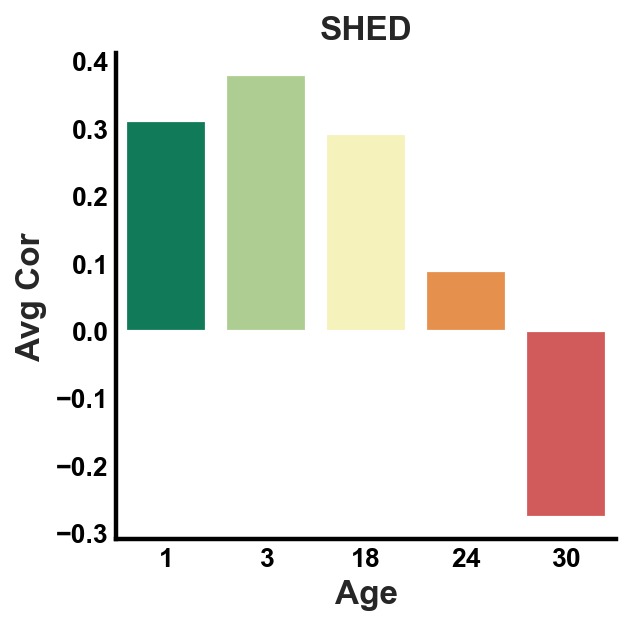

In [54]:
p_d=predicted_age(c57_shed,'SHED',max_gene=20,save_path='result/')

new_cor_pd=pd.DataFrame(columns=['cor','pvalue'])
for i in ['1-','3-','18-','24-','30-']:
  new_cor_pd.loc[i.split('-')[0]]=p_d[p_d.index.str.contains(i)].mean()

pp=plt.figure(figsize=(4,4))
  #用ax控制图片
ax=pp.add_subplot(1,1,1)

sns.barplot(x=new_cor_pd.index,y=new_cor_pd['cor'].tolist(),
            palette=age_color,ax=ax)
ax.grid(None)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
plt.xlabel('Age',fontsize=15,fontweight='bold')
plt.ylabel('Avg Cor',fontsize=15,fontweight='bold')
plt.title('SHED',fontsize=15,fontweight='bold')
plt.grid(False)
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.savefig("result/Fig_cor_{}.png".format('SHED'),dpi=300,bbox_inches = 'tight')

### GSE82106 month 3

In [56]:
gse82106_exp=pd.read_csv('data/GSE82106_Gene_Expression.txt.gz',sep='\t')
gse82106_exp.head()

,TranscriptID,Unnamed: 1,chr,start,end,strand,Length,Annotation/Divergence,CMV1_RPKM,CMV2_RPKM,CMV3_RPKM,CMV4_RPKM,CMV5_RPKM,VEGF1_RPKM,VEGF2_RPKM,VEGF3_RPKM,VEGF4_RPKM,VEGF5_RPKM,CMV vs. VEGF logFC,CMV vs. VEGF FDR
0,NM_029455,NaN,chr2,125809219,125977740,-,1839.0,Fam227b|4930525F21Rik|-|2|2 F1|protein-coding,4.280,6.609,5.728,2.768,1.416,6.002,4.759,7.384,7.019,4.282,5.514715e-02,1.0
1,NR_106086,NaN,chr4,133272965,133273023,-,58.0,Mir7227|mmu-mir-7227|-|-|ncRNA,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-5.125480e-15,1.0
2,NM_144958,NaN,chr11,69480438,69485925,-,1867.0,Eif4a1|BM-010|Ddx2a|Eif4|-|11 B3|11 42.86 cM|p...,162.209,208.547,249.399,144.623,184.431,270.990,227.953,255.819,333.200,187.654,2.883315e-02,1.0
3,NM_028889,NaN,chr1,89160939,89207366,+,1799.0,Efhd1|4931430I01Rik|AI452351|PP3051|mitocalcin...,0.000,0.000,0.000,0.059,0.000,0.000,0.000,0.000,0.000,0.083,-2.351704e-02,1.0
4,NM_027154,NaN,chr1,74334821,74350910,-,2295.0,Tmbim1|2310061B02Rik|AA960455|AU024746|C78899|...,17.871,17.211,27.096,12.477,16.343,25.288,25.226,26.549,27.856,20.782,8.932076e-02,1.0


In [57]:
gse82106_exp['Symbol']=[i.split('|')[0] for i in gse82106_exp['Annotation/Divergence']]
gse82106_exp.set_index(gse82106_exp['Symbol'],inplace=True)
gse82106_exp['CMV1_RPKM']

Symbol
Fam227b            4.280
Mir7227            0.000
Eif4a1           162.209
Efhd1              0.000
Tmbim1            17.871
                  ...   
Sirt6              1.167
Gadd45a           10.658
Hs3st3a1           0.351
Tat               72.058
9130221F21Rik      0.578
Name: CMV1_RPKM, Length: 24016, dtype: float64

/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/fernandozeng/miniforge3/envs/bio/lib/python3.8/site-packages/numpy/core/_meth

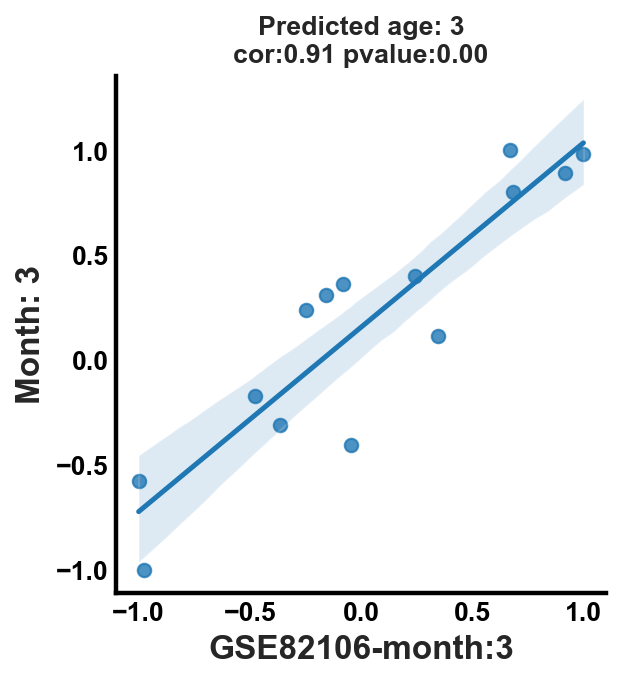

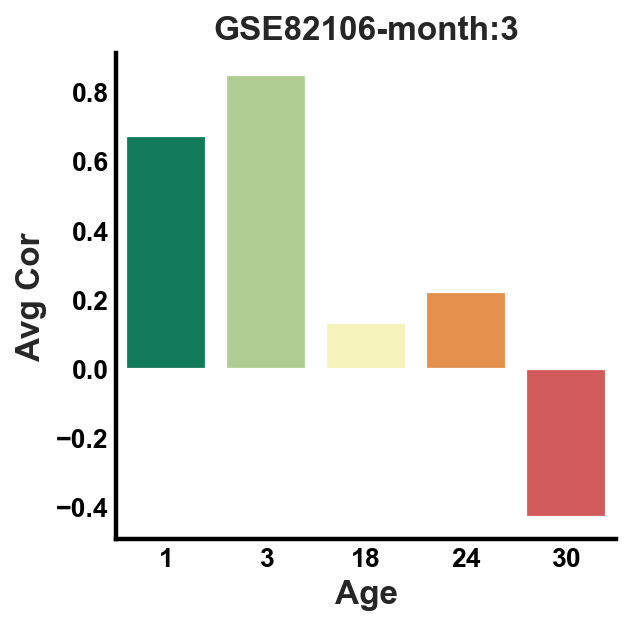

In [58]:
p_d=predicted_age(gse82106_exp['CMV1_RPKM'],'GSE82106-month:3',max_gene=40,save_path='result/')


new_cor_pd=pd.DataFrame(columns=['cor','pvalue'])
for i in ['1-','3-','18-','24-','30-']:
  new_cor_pd.loc[i.split('-')[0]]=p_d[p_d.index.str.contains(i)].mean()

pp=plt.figure(figsize=(4,4))
  #用ax控制图片
ax=pp.add_subplot(1,1,1)

sns.barplot(x=new_cor_pd.index,y=new_cor_pd['cor'].tolist(),
            palette=age_color,ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细
plt.xlabel('Age',fontsize=15,fontweight='bold')
plt.ylabel('Avg Cor',fontsize=15,fontweight='bold')
plt.title('GSE82106-month:3',fontsize=15,fontweight='bold')
plt.grid(False)
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.savefig("result/Fig_cor_{}.png".format('GSE82106-month:3'),dpi=300,bbox_inches = 'tight')